In [45]:
import pandas as pd
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# Data import

## Iris

In [7]:
from sklearn.datasets import load_iris

iris_data = load_iris(return_X_y=False, as_frame=True)
iris_data.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


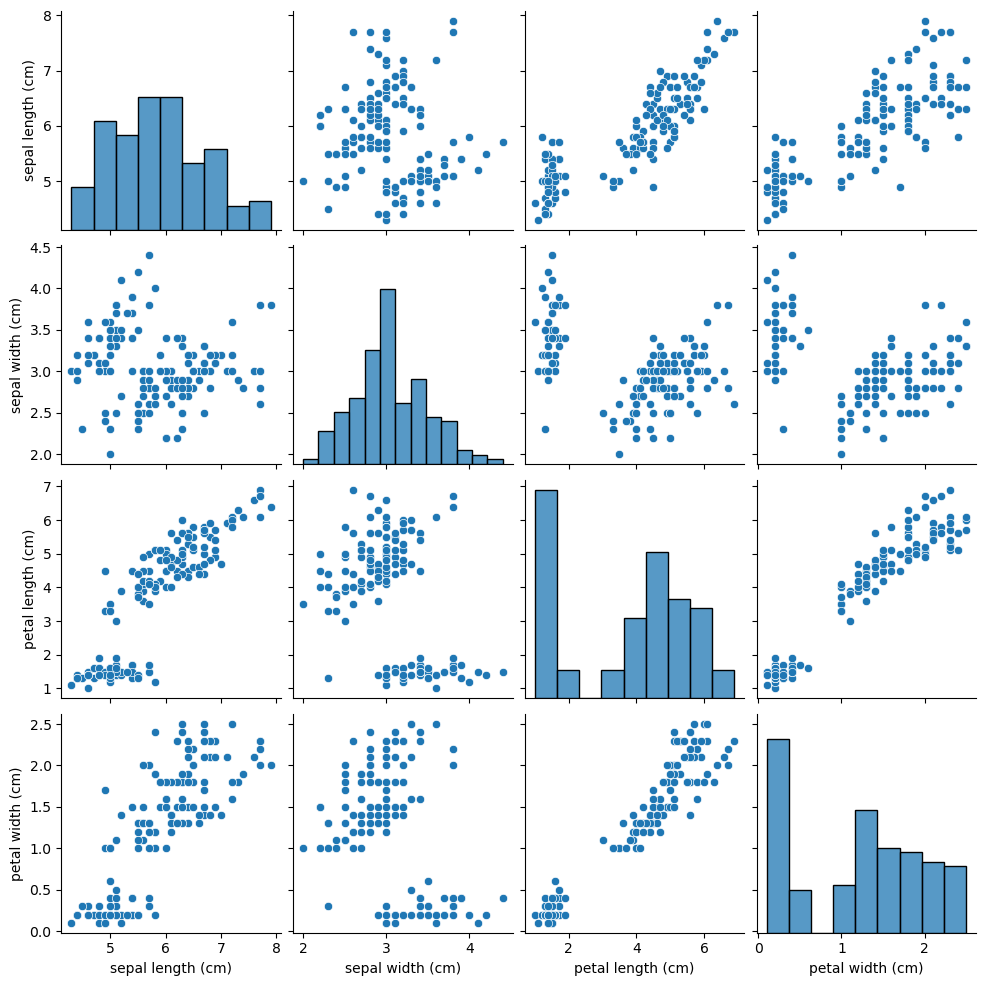

In [8]:
sns.pairplot(iris_data.data)
plt.show()

In [9]:
X = iris_data.data
target_labels = iris_data.target

## Small

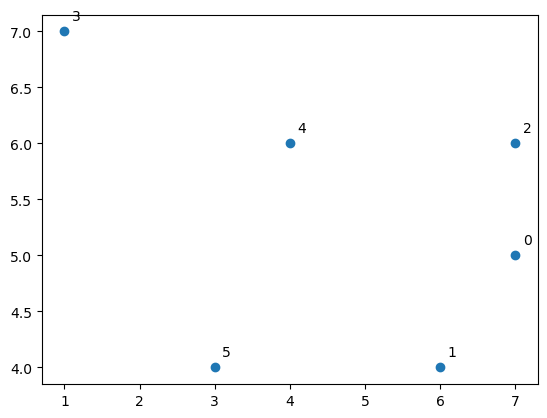

In [26]:
from matplotlib import pyplot as plt
import string

np.random.seed(42*5)

N = 6
X = np.random.randint(0, 10, (N, 2))
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1])

# for i, txt in enumerate(string.ascii_uppercase[:N]):
for i in range(N):
    txt = str(i)
    ax.annotate(txt, (X[i, 0], X[i, 1]), xytext=[X[i, 0]+0.1, X[i, 1]+0.1])

plt.show()

# Algorithms demo

## General functions

In [52]:
from scipy.cluster.hierarchy import fcluster

def get_linkage_matrix(model):
    """Creates linkage matrix Z from sklearn HAC model"""
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

def get_node_labels(linkage_matrix, n_clusters=None, threshold=None):
    """Calculates cluster labels for a given threshold or cluster number"""
    assert n_clusters is not None or threshold is not None, \
        "either n_clusters or threshold should be supplied"

    if n_clusters is not None: 
        node_labels = fcluster(linkage_matrix, linkage_matrix[-n_clusters, 2])
    else:
        node_labels = fcluster(linkage_matrix, threshold, criterion='distance')

    return node_labels

def plot_dendrogram(model, color_threshold=None, **kwargs):
    """Creates linkage matrix and then plots the dendrogram"""

    linkage_matrix = get_linkage_matrix(model)
    node_labels = get_node_labels(linkage_matrix, threshold=color_threshold)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=color_threshold, **kwargs)
    return linkage_matrix, node_labels

In [17]:
# TODO: fix cluster counting

linkage_types = ['ward', 'complete', 'average', 'single']
cutoff_thresholds = [4.5, 2, 1, 0.55]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = ['Уорда', 'Полной связи', "Средней связи", "Одиночной связи"]
linkage_labels = dict(zip(linkage_types, labels))

def visualize(hclust): 
    mpl.rcParams.update(mpl.rcParamsDefault)
    fig, axs = plt.subplots(2, 2)
    axs_indices = [(i, j) for i in range(2) for j in range(2)]
    for linkage_type, axs_ind in zip(linkage_types, axs_indices):
        # if linkage_type in ['ward', 'average']:
        #     continue
        # print(linkage_type)
        _, node_labels = plot_dendrogram(
            model=hclust[linkage_type],
            truncate_mode="level",
            p=4,
            ax=axs[axs_ind],
            labels=None,
            color_threshold = linkage_colors[linkage_type]
            )

        n_clusters = len(np.unique(node_labels))
        title = f"Метод: {linkage_labels[linkage_type]} | Кластеров: {n_clusters}"
        axs[axs_ind].set_title(title, fontsize=20)
        axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')

    # fig.tight_layout()
    fig.set_size_inches(25, 10.5)
    fig.set_dpi(400)
    plt.show()

## NNChain

### Code

In [11]:
from utils import linkage_methods, metric_functions
from utils import compute_distances, tril_idx

class NNChainClustering():
    def __init__(self, n_clusters=2, metric='euclidean', linkage='average'):
        self.n_clusters = n_clusters

        try:
            metric_func = metric_functions[metric]
        except KeyError as e:
            raise ValueError(
                f"Unknown metric."
            ) from e
        
        try:
            join_func = linkage_methods[linkage]
        except KeyError as e:
            raise ValueError(
                f"Unknown linkage. Should be one of {linkage_methods.keys()}"
            ) from e
        if linkage == 'ward' and metric != 'euclidean':
            raise ValueError(
                f"Only euclidean disance is availible for ward's method."
            )

        self._metric_func = metric_func
        self._join_func = join_func

        self.distances_ = None
        self.children_ = None

    def fit(self, X):
        if type(X) == pd.core.frame.DataFrame:
            X = X.to_numpy()

        if self._metric_func != None:
            D = compute_distances(X)
        else:
            D = X

        N = D.shape[0]
        size = np.ones(N)

        self.children_ = np.ndarray((N-1, 2), dtype='int')
        self.distances_ = np.ndarray((N-1))
        self.labels_ = np.arange(N)

        new_node_label = N
        chain = []
        cluster_sizes = np.ones(N)
        node_labels = set(range(N))

        while len(node_labels) > 1:
            if len(chain) < 3:
                a = node_labels[0]
                chain.append(a)
                b = node_labels[1]
            else:
                a = chain[-4]
                b = chain[-3]
                for _ in range(3):
                    chain.pop()

            while True: # find mutual pairs
                min_curr = np.inf

                c = b if b in min_idxs else min_idxs[0] # prefer b
                a, b = c, a

                if len(chain) > 1 and a == chain[-2]:
                    break

                chain.append(c)    

            if a > b:
                a, b = b, a

            node_labels.remove(a)            
            node_labels.add(new_node_label)

            # write to output
            cluster_sizes[b] = cluster_sizes[a] + cluster_sizes[b]
            cluster_sizes[a] = 0
            self.children_[new_node_label - N, :] = [a, b]
            self.distances_[new_node_label - N] = D[a, b]

            # calc distances
            new_dist = np.atleast_2d(self._join_func(a, b, D))
            D[a, b] = new_dist
            D[b, a] = new_dist.T
            
        # sort the unsorted dendrogram
        sorted_idx = self.distances_.argsort()
        self.children_ = self.children_[sorted_idx]
        self.distances_ = self.distances_[sorted_idx]

        return self

### Demo

In [12]:
%%time
# from hierarchical_clustering import NNChainClustering
linkage_types = ['ward', 'complete', 'average', 'single']
hclust_nnc = dict()
for linkage_type in linkage_types:
    model_nnc = NNChainClustering(linkage=linkage_type)
    clustering = model_nnc.fit(X)
    hclust_nnc[linkage_type] = clustering

TypeError: compute_distances() missing 1 required positional argument: 'metric_fn'

In [172]:
linkage_dbg = 'average'
model = hclust_nnc[linkage_dbg]
print(model.children_)

[[142 101]
 [  7  39]
 [  0  17]
 [  9  34]
 [132 128]
 [ 10  48]
 [ 37   4]
 [ 19  21]
 [137 116]
 [ 80  81]
 [ 30  29]
 [ 93  57]
 [  8  38]
 [ 47   3]
 [ 92  82]
 [ 95  96]
 [ 27  28]
 [138 127]
 [ 45   1]
 [ 65  75]
 [ 63  91]
 [150  40]
 [ 49 153]
 [ 12 164]
 [126 123]
 [112 139]
 [ 99  94]
 [ 88 209]
 [ 25 162]
 [ 46 160]
 [  2 163]
 [ 84  66]
 [ 23  26]
 [ 74  97]
 [ 53  89]
 [151 152]
 [ 69 202]
 [154 155]
 [220  78]
 [110 147]
 [143 120]
 [167 165]
 [ 43 159]
 [136 148]
 [ 58  54]
 [144 140]
 [236 103]
 [141 145]
 [211 210]
 [173  42]
 [161  11]
 [ 70 231]
 [156 157]
 [ 67 206]
 [ 68  87]
 [113 242]
 [ 50  52]
 [ 56  51]
 [107 130]
 [122 105]
 [  6 166]
 [ 20  31]
 [171 170]
 [ 13 174]
 [267 266]
 [251  86]
 [104 235]
 [146 229]
 [ 55  90]
 [243 121]
 [204 203]
 [ 73 221]
 [215 241]
 [172 169]
 [149 240]
 [ 83 133]
 [ 18   5]
 [262 115]
 [ 32  33]
 [129 125]
 [270 124]
 [168  35]
 [ 36 180]
 [252  76]
 [212 208]
 [214  71]
 [199  98]
 [265 264]
 [228  72]
 [158 177]
 [237 111]

In [186]:
def _check(Z):
    """_hierarchy_uses_cluster_before_formed"""
    n = Z.shape[0] + 1
    for i in range(0, n - 1):
        if Z[i, 0] >= n + i or Z[i, 1] >= n + i:
            return i
    return False

Z = get_linkage_matrix(hclust_nnc["ward"])
i = _check(Z)
print(i, Z[i].astype(int))

150
27 [206  88   0   1]


In [ ]:
visualize(hclust_nnc)

## Naive clustering

In [46]:
%load_ext autoreload
%autoreload 2
from naive_clustering import NaiveClustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
%%time
linkage_types = ['ward', 'complete', 'average', 'single']
hclust_naive = dict()
for linkage_type in linkage_types:
    model_naive = NaiveClustering(linkage=linkage_type)
    clustering = model_naive.fit(X)
    hclust_naive[linkage_type] = clustering

CPU times: total: 15.6 ms
Wall time: 4.01 ms


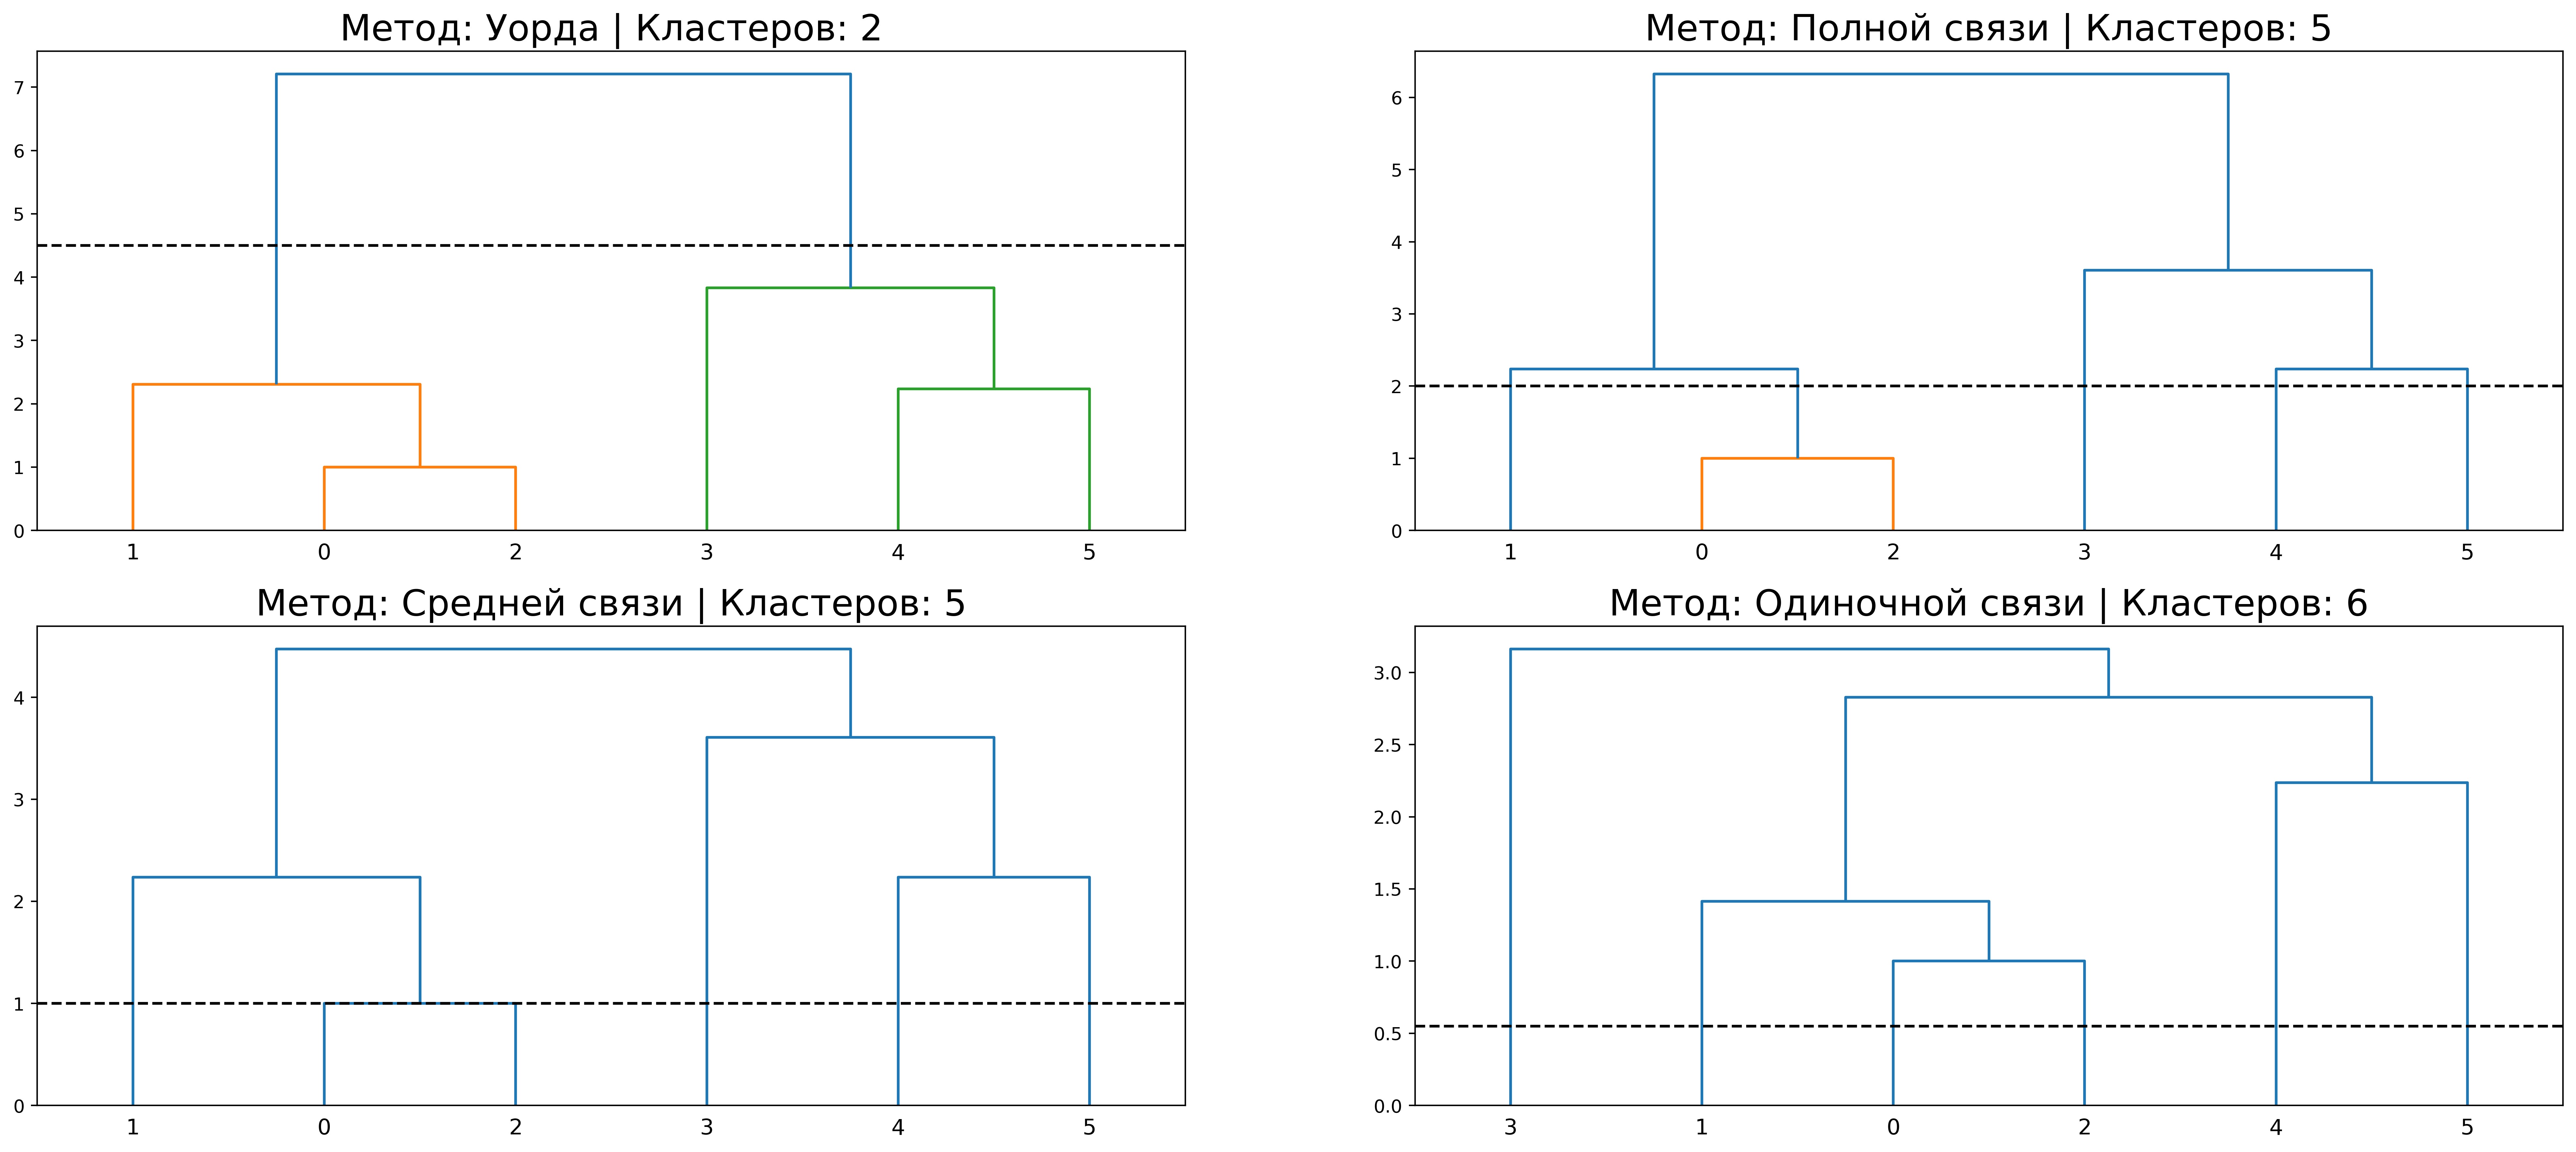

In [48]:
visualize(hclust_naive)

## Sklearn clustering

In [49]:
from sklearn.cluster import AgglomerativeClustering as AC_sklearn

In [50]:
%%time
linkage_types = ['ward', 'complete', 'average', 'single']
hclust_sklearn = dict()
for linkage_type in linkage_types:
    model_sklearn = AC_sklearn(linkage=linkage_type, n_clusters=None,
                                    distance_threshold=0,
                                    compute_distances=True)
    clustering = model_sklearn.fit(X)
    hclust_sklearn[linkage_type] = clustering

CPU times: total: 15.6 ms
Wall time: 3.01 ms


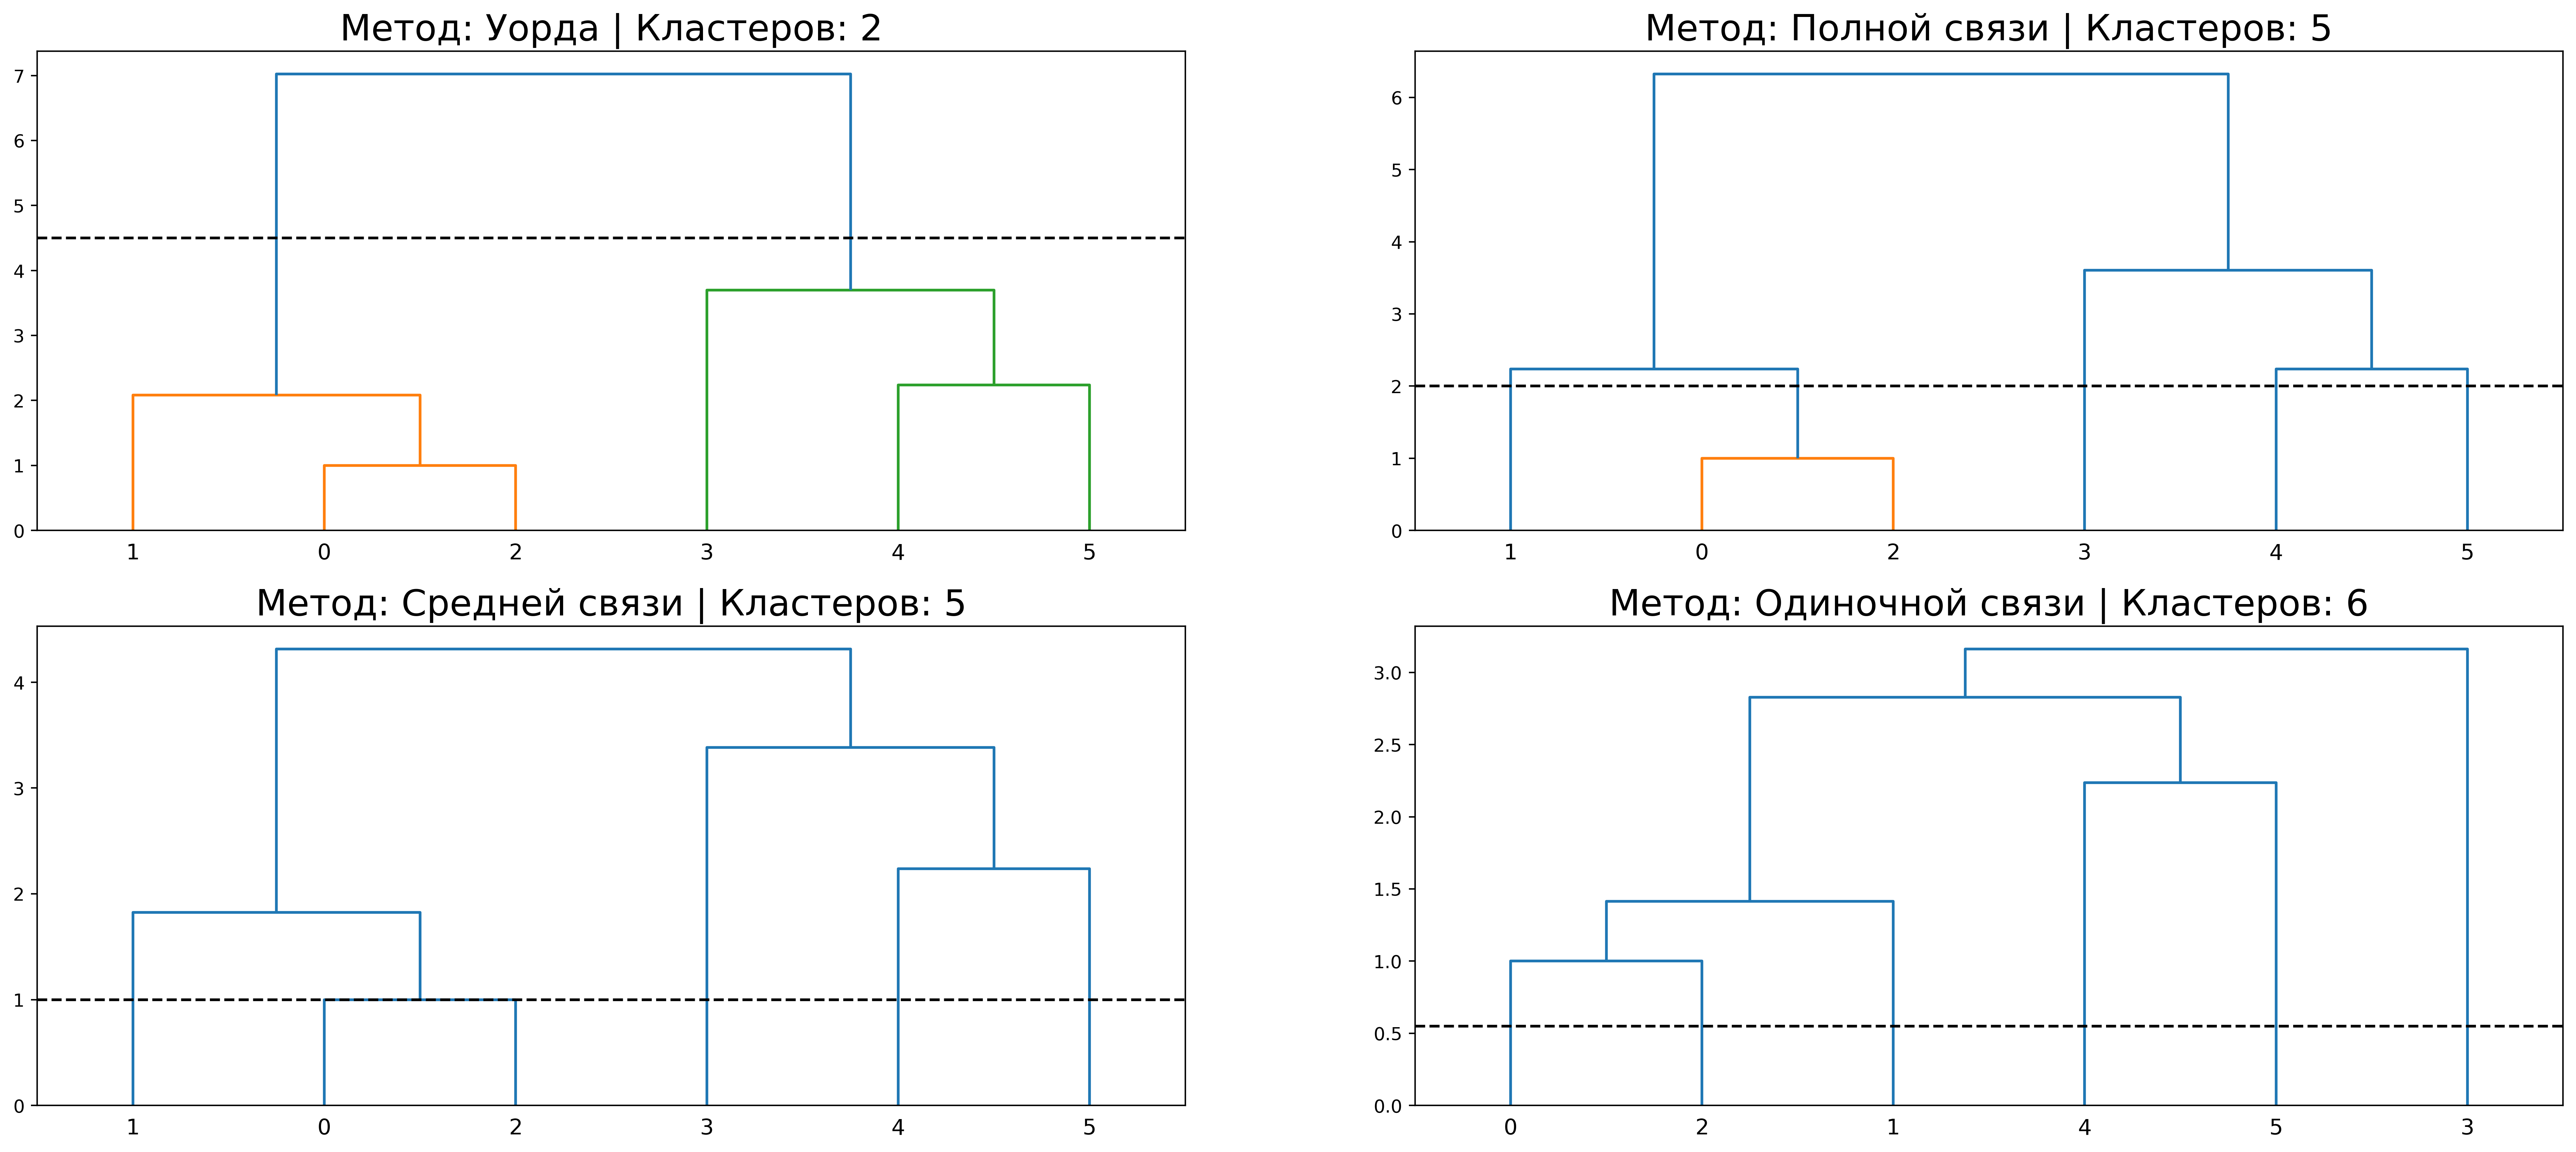

In [51]:
visualize(hclust_sklearn)

# Comparison

In [38]:
linkage_dbg = 'ward'

print(hclust_naive[linkage_dbg].distances_)
hclust_naive[linkage_dbg].children_

[1.   2.24 2.31 3.83 7.21]


array([[0, 2],
       [4, 5],
       [1, 6],
       [3, 7],
       [8, 9]])

In [39]:
print(hclust_sklearn[linkage_dbg].distances_)
hclust_sklearn[linkage_dbg].children_

[1.   2.08 2.24 3.7  7.02]


array([[0, 2],
       [1, 6],
       [4, 5],
       [3, 8],
       [7, 9]], dtype=int64)

In [40]:
linkage_types = ['ward', 'complete', 'average', 'single']

def cmp(hclust1, hclust2):
    for linkage_type in linkage_types:
        isclose_dist = np.allclose(
            hclust1[linkage_type].distances_,
            hclust2[linkage_type].distances_
            )
        isclose_child = np.allclose(
            hclust1[linkage_type].children_,
            hclust2[linkage_type].children_
            )
        print(linkage_type, f"close dist: {isclose_dist}",
              f"close children: {isclose_child}")